In [1]:
%matplotlib inline

import sys, os

# Suppress a single core warning
import warnings
warnings.filterwarnings("ignore")

# Supress warnings from all sub-processes
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
# Data engineering and statistics
import pandas as pd
import numpy as np
import scipy.stats as st

# Model validation
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
)

# Survival analysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from lifelines import KaplanMeierFitter

# Model evaluation
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    integrated_brier_score,
)

# Data visualization
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 100
import forestplot as fp

# Util functions
from utils import timeit, ci, bins

RANDOM_STATE = np.random.RandomState(42)

# 1. Load Data

In [4]:
# Read in pickles
X_clinical = pd.read_pickle("./X_clinical.pkl")
X_radiomic = pd.read_pickle("./X_radiomic.pkl")
y = pd.read_pickle("./y.pkl")

# Re-align X and y
X_clinical = X_clinical.drop(columns="Cohort")
X_merged = X_clinical.merge(X_radiomic, left_index=True, right_index=True)
X_merged = X_merged.merge(y.drop(columns="Cohort"), left_index=True, right_index=True)
X_radiomic = X_merged.drop(columns=["Progression Free Survival", "Censorship"])
y = X_merged[["Progression Free Survival", "Censorship"]]

X_discovery = X_radiomic[X_radiomic["Cohort"] == "Discovery"].drop(columns="Cohort")
X_replicate = X_radiomic[X_radiomic["Cohort"] == "Replicate"].drop(columns="Cohort")

y_discovery = np.array(
    [
        (
            row["Censorship"],
            row["Progression Free Survival"],
        )
        for _, row in y[y.index.isin(X_discovery.index)].iterrows()
    ],
    dtype=[
        ("Censorship", "?"),
        ("Progression Free Survival", "<f8"),
    ],
)
y_replicate = np.array(
    [
        (
            row["Censorship"],
            row["Progression Free Survival"],
        )
        for _, row in y[y.index.isin(X_replicate.index)].iterrows()
    ],
    dtype=[
        ("Censorship", "?"),
        ("Progression Free Survival", "<f8"),
    ],
)

# 2. Discovery

## 2.1 Train, Validate, and Test

In [14]:
# Don't penalize clinical, but radiomic features
penalty_factor = np.ones(X_discovery.shape[1])
penalty_factor[:X_clinical.shape[1]] = [0] * X_clinical.shape[1]

# Definte estimator and cross-validation
estimator = CoxnetSurvivalAnalysis(
    penalty_factor=penalty_factor, max_iter=100, fit_baseline_model=True
)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Run nested cross-validation with optimal hyperparameters
print("🚀 Outer CV started!")
outer_s = time.time()
inner_c = 1
cv_results = []
for train, test in outer_cv.split(X_discovery, y_discovery["Censorship"]):
    try:
        print(f"  🧵 Inner CV {inner_c} running...")
        inner_s = time.time()
        
        X_train, X_test = X_discovery.iloc[train, :], X_discovery.iloc[test, :]
        y_train, y_test = y_discovery[train], y_discovery[test]
    
        # Fit estimator
        estimator.fit(X_train, y_train)
    
        # Get an initial set of alpha
        estimated_alphas = estimator.alphas_
    
        # Define and fit grid search cross-validation
        gcv = GridSearchCV(
            estimator,
            {
                "alphas": [[alpha] for alpha in estimated_alphas],
                "l1_ratio": np.arange(0.1, 1.0, 0.1),
            },
            n_jobs=-1,
            cv=inner_cv.split(X_train, y_train["Censorship"]),
            error_score="raise",
        ).fit(X_train, y_train)
    
        # Get best estimator
        best_estimator = gcv.best_estimator_
    
        # Predict against the fitted estimator
        pred = best_estimator.predict(X_test)
    
        # Compute Concordance indexes
        har = concordance_index_censored(
            y_test["Censorship"], y_test["Progression Free Survival"], pred
        )[0]
        uno = concordance_index_ipcw(y_train, y_test, pred)[0]
    
        # IBS
        survs = best_estimator.predict_survival_function(X_test)
        lower, upper = np.percentile(y_test["Progression Free Survival"], [25, 75])
        times = np.arange(lower, upper + 1)
        preds = np.asarray([[fn(t) for t in times] for fn in survs])
        ibs = integrated_brier_score(y_train, y_test, preds, times)
    
        cv_results.append(
            {
                "best_estimator": best_estimator,
                "har": har,
                "uno": uno,
                "ibs": ibs,
            }
        )

        print(f"  ✅ Inner CV {inner_c} elapsed: {timeit(inner_s)}")
    except Exception as e:
        print(f"  🐛 Inner CV {inner_c} errored: {e}")
    finally:
        inner_c += 1

print(f"📦️ Outer CV elapsed: {timeit(outer_s)}")

# Print results
cv_results = pd.DataFrame(cv_results)
cv_results[
    [
        "har",
        "uno",
        "ibs",
    ]
].mean()

har    0.713868
uno    0.718686
ibs    0.242701
dtype: float64

In [15]:
cv_results

,best_estimator,har,uno,ibs
0,CoxnetSurvivalAnalysis(alphas=[0.1356717730503...,0.666667,0.902392,0.223384
1,CoxnetSurvivalAnalysis(alphas=[0.0932991014419...,0.608696,0.608569,0.257356
2,CoxnetSurvivalAnalysis(alphas=[0.0984993393221...,0.826087,0.862086,0.227899
3,CoxnetSurvivalAnalysis(alphas=[0.0194051114387...,0.450000,0.498234,0.384401
4,CoxnetSurvivalAnalysis(alphas=[0.0814045702709...,0.849057,0.752485,0.130722
5,CoxnetSurvivalAnalysis(alphas=[0.1557994142377...,0.863636,0.768574,0.122875
6,CoxnetSurvivalAnalysis(alphas=[0.0228960102716...,0.750000,0.759578,0.222163
7,CoxnetSurvivalAnalysis(alphas=[0.0220699247956...,0.725000,0.669283,0.260009
8,CoxnetSurvivalAnalysis(alphas=[0.0103065439524...,0.780488,0.764314,0.265089
9,CoxnetSurvivalAnalysis(alphas=[0.0326355563759...,0.619048,0.601351,0.333115


In [16]:
# Print results
scorings = ["har", "uno", "ibs"]
for scoring in scorings:
    c, u, l, h = ci(cv_results[scoring])
    print(f"{scoring} {c} CI: {u} [{l}, {h}]")

95% CI of har: (0.6335667159050732, 0.794168817434514)
95% CI of uno: (0.6417635408283948, 0.7956093197419973)
95% CI of ibs: (0.193298543796604, 0.29210417615798306)


## 2.2 Group Risk Scores

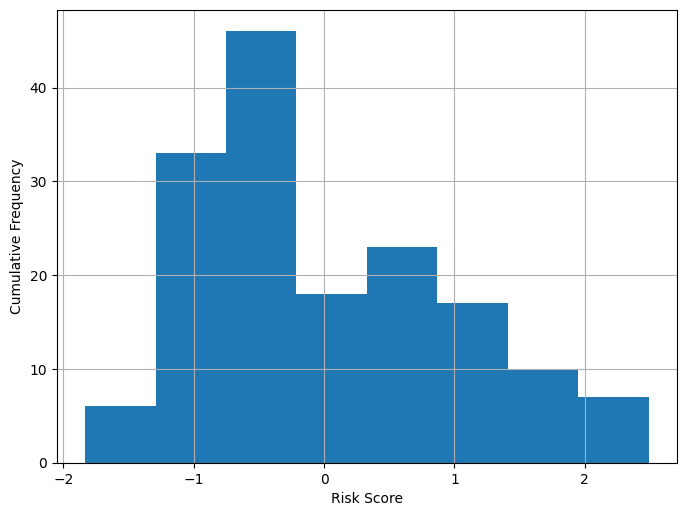

In [18]:
# Get best estimator
estimator = cv_results.iloc[np.argmax(cv_results.uno), :].best_estimator

# Fit estimator against the entire data set
estimator.fit(X_discovery, y_discovery)

# Predict against the fitted estimator
risk_discovery = estimator.predict(X_discovery)

# Type-case to data frame
risk_discovery = pd.DataFrame(risk_discovery, columns=["Risk Score"])

# Investigate distribution
risk_discovery["Risk Score"].hist(bins=bins(risk_discovery["Risk Score"].shape[0]))

plt.xlabel("Risk Score")
plt.ylabel("Cumulative Frequency")

# Visualize distribution
plt.savefig("./dt_discovery.png")
plt.show()

# Group risk scores
lower, upper = np.quantile(risk_discovery["Risk Score"], [0.25, 0.75])
risk_discovery["Risk Group"] = risk_discovery["Risk Score"].apply(
    lambda x: "High" if x > upper else "Medium" if x > lower else "Low"
)

# Set subject ID
risk_discovery = risk_discovery.set_index(X_discovery.index)

# Set output features
risk_discovery["Censorship"] = y_discovery["Censorship"]
risk_discovery["Progression Free Survival"] = y_discovery["Progression Free Survival"]

risk_discovery.to_csv("./rs_discovery.csv")

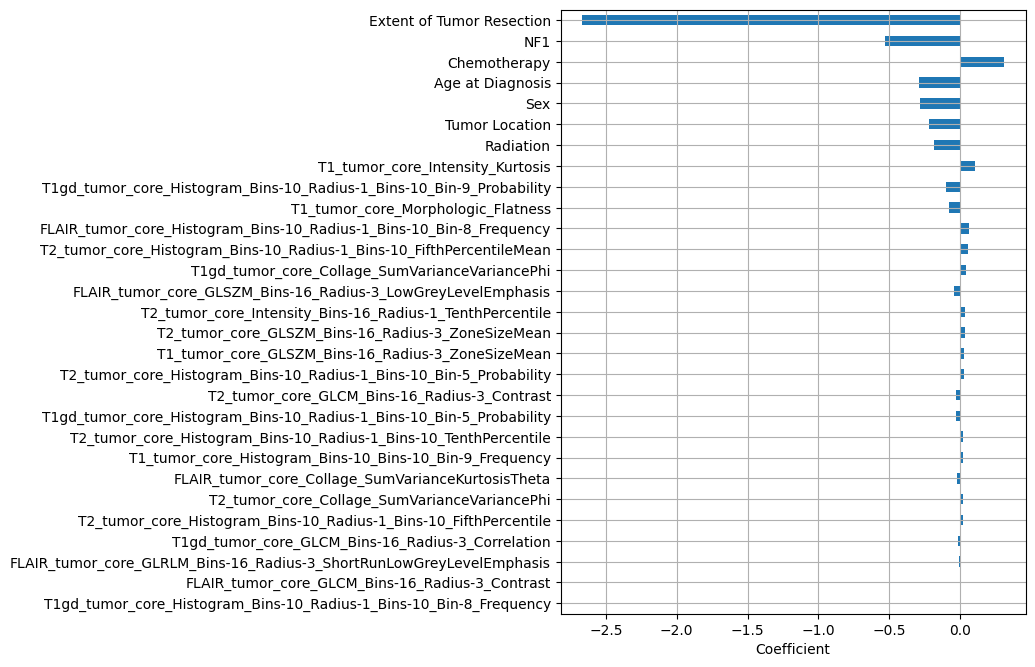

In [20]:
# Explore coefficients
coef = pd.DataFrame(estimator.coef_, index=X_discovery.columns, columns=["coef"])
coef = coef.query("coef != 0")

# Visualize coefficients
_, ax = plt.subplots(figsize=(6, 8))
coef.loc[coef.abs().sort_values("coef").index].plot.barh(ax=ax, legend=False)
ax.set_xlabel("Coefficient")
ax.grid(True)

plt.savefig("./ce_discovery.png")
plt.show()

## 2.3 Visualize Results

In [21]:
# Run one-way ANOVA
statistic, pvalue = st.f_oneway(
    risk_discovery[risk_discovery["Risk Group"] == "High"]["Risk Score"],
    risk_discovery[risk_discovery["Risk Group"] == "Medium"]["Risk Score"],
    risk_discovery[risk_discovery["Risk Group"] == "Low"]["Risk Score"],
)
print(statistic, pvalue)

345.55271075918245 3.1247143183123804e-58


### 2.3.1 KM Curves

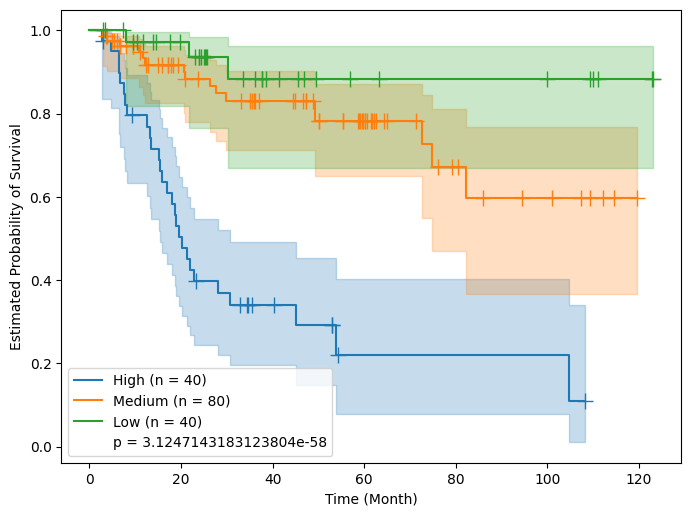

In [22]:
survival_table_discovery = None
for val in [
    "High",
    "Medium",
    "Low"
]:
    mask = risk_discovery["Risk Group"] == val
    kmf = KaplanMeierFitter()
    kmf.fit(
        risk_discovery["Progression Free Survival"][mask],
        event_observed=risk_discovery["Censorship"][mask],
        label=f"{val} (n = {mask.sum()})",
    )
    
    # Create a survival table
    kmf.event_table["event_at"] = kmf.event_table.index
    kmf.event_table["Time (Month)"] = (kmf.event_table["event_at"] // 20) * 20
    num_at_risk = (
        kmf.event_table.groupby("Time (Month)")["at_risk"].min().rename(index=val)
    )
    survival_table_discovery = (
        num_at_risk
        if survival_table_discovery is None
        else pd.concat(
            [
                survival_table_discovery,
                num_at_risk,
            ],
            axis=1,
        )
    )
    
    kmf.plot(show_censors=True)

plt.xlabel("Time (Month)")
plt.ylabel("Estimated Probability of Survival")

# Create empty plot with blank marker containing the extra label
plt.plot([], [], " ", label=f"p = {pvalue}")

# Add legend
plt.legend(loc="lower left")

plt.savefig("./km_discovery.png")
plt.show()

### 2.3.2 Survival Table

In [23]:
print(survival_table_discovery.T.fillna(0))
survival_table_discovery.T.fillna(0).to_csv("./st_discovery.csv")

Time (Month)  0.0    20.0   40.0   100.0  60.0   80.0   120.0
High           20.0    9.0    3.0    1.0    0.0    0.0    0.0
Medium         55.0   42.0   25.0    1.0   11.0    7.0    0.0
Low            28.0   13.0    8.0    3.0    7.0    0.0    1.0


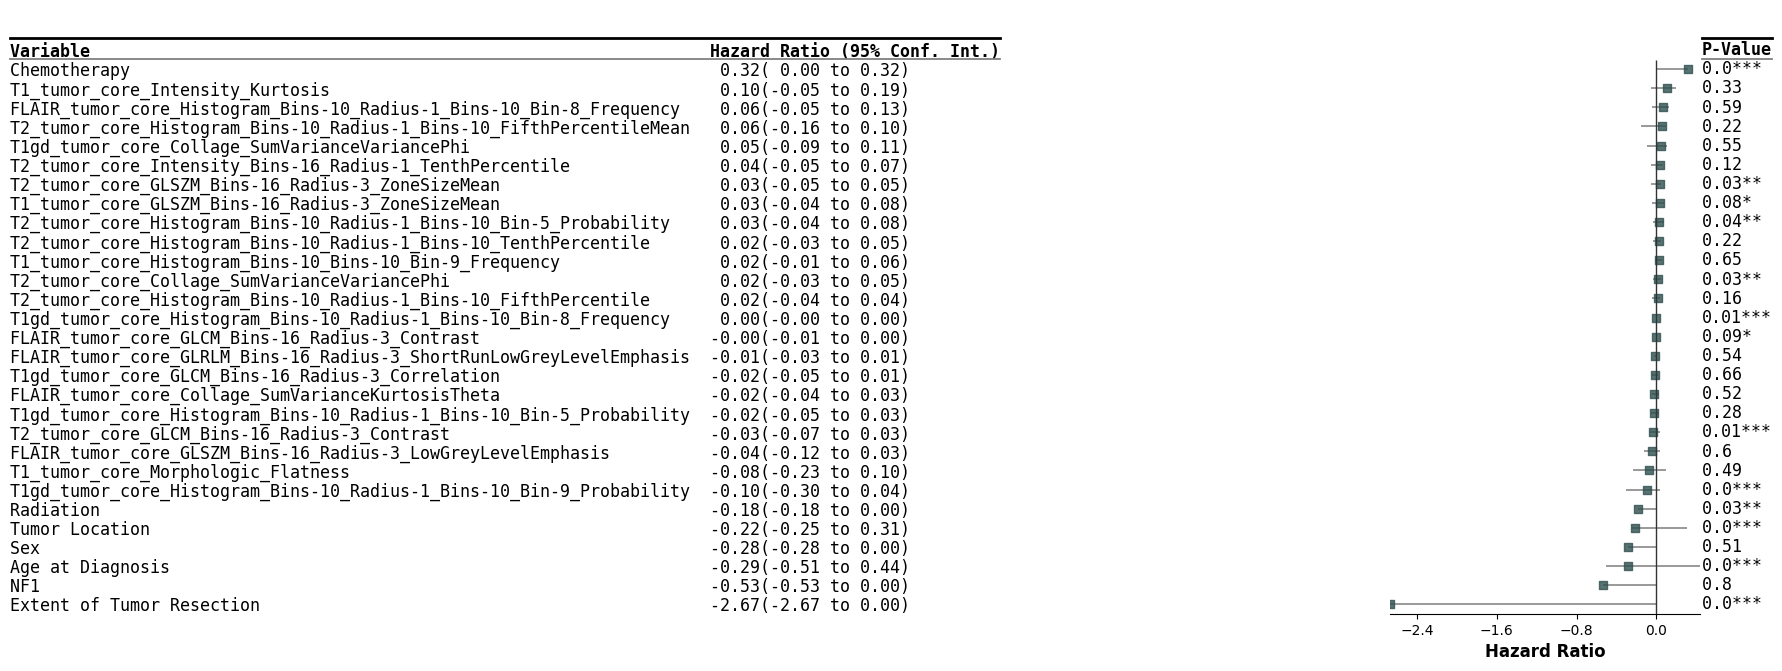

In [24]:
conf = (
    (X_discovery * estimator.coef_.reshape(X_discovery.shape[1]))
    .merge(risk_discovery, left_index=True, right_index=True)
    .drop(columns=["Risk Score", "Censorship", "Progression Free Survival"])
)

forest = {}
for feature in coef.index:
    statistic, pvalue = st.f_oneway(
        conf[conf["Risk Group"] == "High"][feature],
        conf[conf["Risk Group"] == "Medium"][feature],
        conf[conf["Risk Group"] == "Low"][feature],
    )
    forest.setdefault(feature, {})["pvalue"] = pvalue

for feature, ci in (
    conf.agg(
        {
            feature: lambda x: x.quantile([0.025, 0.975])
            for feature in coef.index
        }
    )
    .to_dict()
    .items()
):
    forest[feature].update(ci)

forest = pd.DataFrame(forest).T

forest["Feature"] = forest.index
forest["Hazard Ratio"] = coef
forest = forest.rename(
    columns={
        "pvalue": "P-Value",
        0.025: "2.5%",
        0.975: "97.5%",
    }
)
forest = forest[
    [
        "Feature",
        "2.5%",
        "97.5%",
        "Hazard Ratio",
        "P-Value",
    ]
]

# Visualize a forest plot
fp.forestplot(
    forest,
    estimate="Hazard Ratio",
    ll="2.5%",
    hl="97.5%",
    varlabel="Feature",
    sort=True,
    pval="P-Value",
    annote=["est_ci"],
    annoteheaders=["Hazard Ratio (95% Conf. Int.)"],
    rightannote=["formatted_pval"],
    right_annoteheaders=["P-Value"],
    xlabel="Hazard Ratio",
    table=True,
)
plt.tight_layout()

plt.savefig("./fp_discovery.png")
plt.show()

# 3. Replicate

## 3.1 Predict

In [25]:
# Predict against the fitted estimator
pred = estimator.predict(X_replicate)

# Compute Concordance indexes
har = concordance_index_censored(
    y_replicate["Censorship"], y_replicate["Progression Free Survival"], pred
)[0]
uno = concordance_index_ipcw(y_replicate, y_replicate, pred)[0]

# IBS
survs = estimator.predict_survival_function(X_replicate)
lower, upper = np.percentile(y_replicate["Progression Free Survival"], [25, 75])
times = np.arange(lower, upper + 1)
preds = np.asarray([[fn(t) for t in times] for fn in survs])
ibs = integrated_brier_score(y_replicate, y_replicate, preds, times)

print(har, uno, ibs)

0.7682619647355163 0.7972668959648819 0.1634412347448137


## 3.2 Group Risk Score

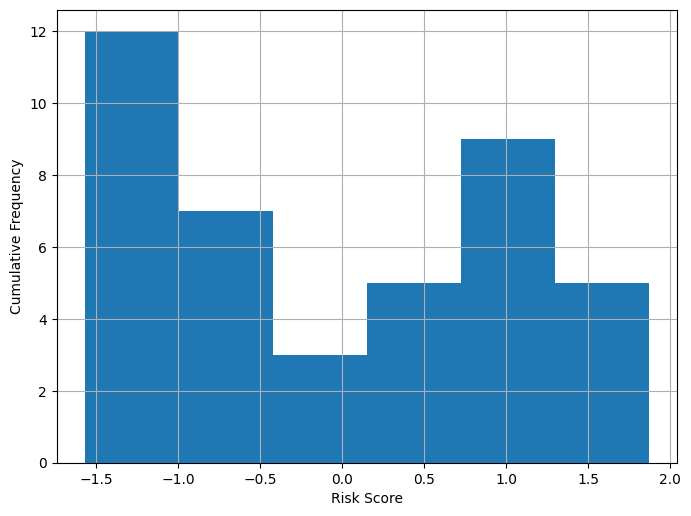

In [27]:
# Predict against the fitted estimator
risk_replicate = estimator.predict(X_replicate)

# Type-case to data frame
risk_replicate = pd.DataFrame(risk_replicate, columns=["Risk Score"])

# Investigate distribution
risk_replicate["Risk Score"].hist(bins=bins(risk_replicate["Risk Score"].shape[0]))

plt.xlabel("Risk Score")
plt.ylabel("Cumulative Frequency")

# Visualize distribution
plt.show()

# Group risk scores
lower, upper = np.quantile(risk_discovery["Risk Score"], [0.25, 0.75])
risk_replicate["Risk Group"] = risk_replicate["Risk Score"].apply(
    lambda x: "High" if x > upper else "Medium" if x > lower else "Low"
)

# Set subject ID
risk_replicate = risk_replicate.set_index(X_replicate.index)

# Set output features
risk_replicate["Censorship"] = y_replicate["Censorship"]
risk_replicate["Progression Free Survival"] = y_replicate["Progression Free Survival"]

risk_replicate.to_csv("./rs_replicate.csv")

## 3.3 Visualize Results

In [28]:
# Run one-way ANOVA
statistic, pvalue = st.f_oneway(
    risk_replicate[risk_replicate["Risk Group"] == "High"]["Risk Score"],
    risk_replicate[risk_replicate["Risk Group"] == "Medium"]["Risk Score"],
    risk_replicate[risk_replicate["Risk Group"] == "Low"]["Risk Score"],
)
print(statistic, pvalue)

179.32540684618232 4.427205634241137e-20


### 3.3.1 KM Curves

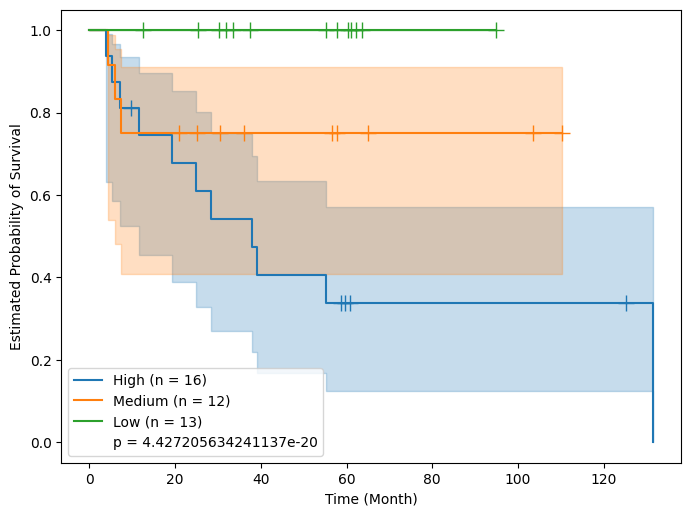

In [29]:
survival_table_replicate = None
for val in [
    "High",
    "Medium",
    "Low"
]:
    mask = risk_replicate["Risk Group"] == val
    kmf = KaplanMeierFitter()
    kmf.fit(
        risk_replicate["Progression Free Survival"][mask],
        event_observed=risk_replicate["Censorship"][mask],
        label=f"{val} (n = {mask.sum()})",
    )
    
    # Create a survival table
    kmf.event_table["event_at"] = kmf.event_table.index
    kmf.event_table["Time (Month)"] = (kmf.event_table["event_at"] // 20) * 20
    num_at_risk = (
        kmf.event_table.groupby("Time (Month)")["at_risk"].min().rename(index=val)
    )
    survival_table_replicate = (
        num_at_risk
        if survival_table_replicate is None
        else pd.concat(
            [
                survival_table_replicate,
                num_at_risk,
            ],
            axis=1,
        )
    )
    
    kmf.plot(show_censors=True)

plt.xlabel("Time (Month)")
plt.ylabel("Estimated Probability of Survival")

# Create empty plot with blank marker containing the extra label
plt.plot([], [], " ", label=f"p = {pvalue}")

# Add legend
plt.legend(loc="lower left")

plt.savefig("./km_replicate.png")
plt.show()

### 3.3.2 Survival Table

In [30]:
print(survival_table_replicate.T.fillna(0))
survival_table_replicate.T.fillna(0).to_csv("./st_replicate.csv")

Time (Month)  0.0    20.0   40.0   60.0   120.0  100.0  80.0 
High           11.0    7.0    4.0    3.0    1.0    0.0    0.0
Medium         10.0    6.0    4.0    3.0    0.0    1.0    0.0
Low            13.0    8.0    6.0    2.0    0.0    0.0    1.0
